# INSTRUCTIONS

Workflow: Run each cell in order. Put or extract data into relevant folders as defined in section 2. Make remaining folders in drive.  **Cells denoted with * may require extra action.**


```
Folder Structure Suggested for Section 2:
drive/
    train_data/ <- input midis go here
    train_output/
        graphs/ <- train/val accuracy plots go here
        intermed/ <- intermediate weights, preprocessing go here
        stats/ (currently not being used)
        midi/ <- output midis go here
```




# 1 Imports

In [1]:
# Import Data Manip, Debug
import glob
import pickle
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt

# Import Music21
!pip install music21
from music21 import converter, instrument, note, chord, stream

# Import Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.regularizers import L1L2
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import History

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# stuff needed for colaboratory to connect with drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


# 2 Mount and Set Directories*

In [3]:
# mount drive
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
DATA_FOLDER = 'drive/Project/train_data/rock_all'
GRAPHS_FOLDER = 'drive/Project/train_output/graphs'
MIDI_OUTPUT_FOLDER = 'drive/Project/train_output/midi'
INTERMED_FOLDER = 'drive/Project/train_output/intermed'
STATS_FOLDER = 'drive/Project/train_output/stats'

# data specific
ROCK_CORPUS = '/rock_'

# SET THIS TO ONE OF ABOVE (ACTION)
CORPUS = ROCK_CORPUS

# Notewise Root and Rest Learning

# 3 Set Training Parameters*

In [0]:
# SET PARAMETERS (ACTION)
RESTS = True
ROOT_EXTRACTION = True
DURATION_BATCH_SIZE = 256
NOTE_BATCH_SIZE = 128
# SPECIFY PARAMETERS TO TEST AS LIST
DROPOUTS = 0
MODEL_SIZES = 256
EPOCHS = 10

# 4 Preprocess Data (MIDI Data Into Notes Corpus and Duration Corpus)

In [6]:
# Test

notes_corpus = []
durations_corpus = []

for file in glob.glob(DATA_FOLDER + "/*.mid"):
    try:
      print("Extracting MIDI File: ", file)
      midi_stream = converter.parse(file)

      notes = None

      partition = instrument.partitionByInstrument(midi_stream)

      if not RESTS:
        # No rests
        if partition: 
            notes = partition.parts[0].recurse()
        else: 
            notes = midi_stream.flat.notes
      else:
        # With rests
        if partition: 
            notes = partition.parts[0].recurse()
        else: 
            notes = midi_stream.notesAndRests
          
      count 
      
      in_song_notes = []
      in_song_durations = []
      for element in notes:
          in_song_durations.append(element.duration.quarterLength)
          if isinstance(element, note.Note):
              in_song_notes.append(str(element.pitch))
          elif RESTS and isinstance(element, note.Rest):
              in_song_notes.append("R")
          elif isinstance(element, chord.Chord):
              if ROOT_EXTRACTION:
                  in_song_notes.append(element.root().nameWithOctave)
              else:
                  in_song.append('.'.join(str(n) for n in element.normalOrder))
    except:
      pass
    
    notes_corpus.append(in_song_notes)
    durations_corpus.append(in_song_durations)
            
# Write
with open(INTERMED_FOLDER + CORPUS + 'notes_corpus', 'wb+') as filepath:
    pickle.dump(notes_corpus, filepath)
    
with open(INTERMED_FOLDER + CORPUS + 'durations_corpus', 'wb+') as filepath:
    pickle.dump(durations_corpus, filepath)

Extracting MIDI File:  drive/Project/train_data/rock_all/17613.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17600.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17604.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17614.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17612.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17615.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17608.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17609.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17607.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17606.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17610.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17622.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17619.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17624.mid
Extracting MIDI File:  drive/Project/train_data/rock_all/17616

# 5 Preprocess Corpus Into Train Data

## 5.1 Notes Corpus

In [6]:
# load notes corpus
with open(INTERMED_FOLDER + CORPUS + 'notes_corpus', 'rb') as filepath:
    notes_corpus = pickle.load(filepath)
    
# If doing learning for one song at a time only
flattened_notes_corpus = []
for song_notes in notes_corpus:
    flattened_notes_corpus += song_notes

vocab_size = len(set(flattened_notes_corpus))
print(vocab_size)

# Produce input output sequences
window_size = 60
note_sequence_input = []
next_note_output = []

notes = sorted(set(flattened_notes_corpus))
note2int = dict((note, num) for num, note in enumerate(notes))

for i in range(0, len(notes_corpus)):
    for j in range(0, len(notes_corpus[i]) - window_size):
        current_sequence = [note2int[note] for note in notes_corpus[i][j:window_size+j]]
        next_note = note2int[notes_corpus[i][window_size+j]]
        note_sequence_input.append(current_sequence)
        next_note_output.append(next_note)

96


In [7]:
# check train and label shapes
training_data = np.reshape(note_sequence_input, (len(note_sequence_input), window_size , 1))
training_data = training_data / float(vocab_size)
print('Train shape: ' + str(training_data.shape))
training_label = np_utils.to_categorical(next_note_output)
print('Label shape: ' + str(training_label.shape))

Train shape: (1084611, 60, 1)
Label shape: (1084611, 96)


## 5.2 Durations Corpus

In [8]:
# load notes corpus
with open(INTERMED_FOLDER + CORPUS + 'durations_corpus', 'rb') as filepath:
    duration_corpus = pickle.load(filepath)

# Learn on one song at a time
flattened_duration_corpus = []
for song_durations in duration_corpus:
    flattened_duration_corpus += song_durations
    
# import collections
# counter = collections.Counter(flattened_duration_corpus)
# print(counter)


duration_vocab_size = len(set(flattened_duration_corpus))
print(duration_vocab_size)

# Produce input output sequences
duration_window_size = 5
duration_sequence_input = []
next_duration_output = []

durations = sorted(set(flattened_duration_corpus))
duration2int = dict((duration, num) for num, duration in enumerate(durations))

print(duration2int)
# # Write
# with open(INTERMED_FOLDER + CORPUS + "duration_counter", 'wb+') as filepath:
#     pickle.dump(counter, filepath)

for i in range(0, len(duration_corpus)):
    for j in range(0, len(duration_corpus[i]) - duration_window_size):
        current_duration_sequence = [duration2int[note] for note in duration_corpus[i][j:duration_window_size+j]]
        next_duration = duration2int[duration_corpus[i][duration_window_size+j]]
        duration_sequence_input.append(current_duration_sequence)
        next_duration_output.append(next_duration)

Counter({0.5: 398399, 0.25: 299638, 1.0: 111305, 0.0: 109390, Fraction(1, 3): 56808, 0.75: 31270, 1.5: 23660, Fraction(2, 3): 19451, Fraction(1, 6): 17188, 2.0: 13568, 4.0: 6715, Fraction(4, 3): 5596, 1.25: 5112, 2.5: 4855, 3.0: 4536, Fraction(1, 12): 3938, 1.75: 3291, 8.0: 2132, 3.5: 2067, 4.5: 1300, Fraction(5, 3): 1262, 2.25: 1104, 2.75: 1056, 3.75: 974, 5.0: 886, Fraction(7, 3): 819, 3.25: 782, 6.0: 714, Fraction(8, 3): 674, Fraction(5, 12): 645, 7.0: 612, Fraction(11, 3): 520, 6.5: 474, Fraction(7, 6): 463, Fraction(10, 3): 445, 5.5: 371, 16.0: 330, 7.5: 320, 4.75: 309, 5.75: 299, 4.25: 276, Fraction(5, 6): 264, 12.0: 213, 8.5: 190, 7.75: 171, 6.25: 165, 32.0: 163, 5.25: 130, Fraction(23, 3): 129, 9.0: 127, Fraction(13, 6): 124, 7.25: 120, 10.0: 114, Fraction(7, 12): 100, Fraction(13, 3): 95, 6.75: 94, Fraction(17, 3): 92, 9.5: 88, Fraction(20, 3): 84, 24.0: 77, Fraction(11, 12): 76, 64.0: 68, 14.0: 67, 15.0: 65, Fraction(16, 3): 62, 20.0: 61, Fraction(14, 3): 54, 11.0: 52, Fracti

In [9]:
# check train and label shapes
duration_training_data = np.reshape(duration_sequence_input, (len(duration_sequence_input), duration_window_size , 1))
duration_training_data = duration_training_data / float(duration_vocab_size)
print('Train shape: ' + str(duration_training_data.shape))
duration_training_label = np_utils.to_categorical(next_duration_output)
print('Label shape: ' + str(duration_training_label.shape))

Train shape: (1137481, 5, 1)
Label shape: (1137481, 1660)


# 6 Train

## 6.1 Helpers to Create Model

In [0]:
def create_model(network_input, n_vocab, model_size, dropout):
  model = Sequential()
  reg = L1L2(0, 0)
  model.add(LSTM(
      model_size,
      input_shape=(network_input.shape[1], network_input.shape[2]),
      return_sequences=True,
      dropout=dropout, recurrent_dropout=0.3
  ))
  model.add(CuDNNLSTM(model_size, return_sequences=True, kernel_regularizer=reg))
  model.add(Dropout(dropout))
  model.add(CuDNNLSTM(model_size, kernel_regularizer=reg))
  model.add(Dense(128))
  model.add(Dropout(dropout))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_callback_list(model_size, dropout, model_type):
  filepath = INTERMED_FOLDER + '/%skarpathy-model-weights-%s-%s-%s.hdf5' % (CORPUS, model_type, model_size, dropout)
  model_checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
  )
  return [model_checkpoint], filepath

# acc history
def setup_plot(dropout, size):
  plt.title('Model Accuracy vs. Epoc with Dropout=%s Size=%s' % (dropout, size))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  
def plot_history(history, model_type, dropout, size):
  plt.plot(history.history['acc'], label="%s train accuracy" % model_type)
  plt.plot(history.history['val_acc'], label="%s val accuracy" % model_type)

def save_plot(file_path):
  plt.legend()
  plt.savefig(file_path)
  plt.clf()
  
def predict_duration(model, WEIGHT_PATH):
  # Prediction
  model.load_weights(WEIGHT_PATH)
  starting_sequence = np.random.randint(219, size=duration_window_size)
  pattern_sequence = starting_sequence.tolist()
  prediction_output = []

  duration2note = dict((num, note) for num, note in enumerate(durations))
  print (duration2note)
  
  for i in range(400):
      prediction_input = np.reshape(pattern_sequence, (1, len(pattern_sequence), 1))
      prediction_input = prediction_input / float(duration_vocab_size)

      if i%3 == 0:   
          print('\r', 'Predicting.  Duration: ', i, end='')  
      if i%3 == 1:   
          print('\r', 'Predicting.. Duration: ', i, end='')
      if i%3 == 2:   
          print('\r', 'Predicting...Duration: ', i, end='')
      prediction = model.predict(prediction_input, verbose=0)

      prediction_values = np.arange(len(prediction[0]))
      prediction_prob = np.asarray(list(prediction[0])) / float(sum(prediction[0]))

      # Most probable note prediction
#       index = np.argmax(prediction)
#       note_instance = duration2note[index]
#       prediction_output.append(note_instance)
      index = np.random.choice(prediction_values, 1, p=prediction_prob)
      note_instance = duration2note[int(index[0])]
      prediction_output.append(note_instance)

      pattern_sequence.append(index)
      pattern_sequence = pattern_sequence[1:len(pattern_sequence)]    

  prediction_output = prediction_output[300:len(prediction_output)]

  # Write
  with open(INTERMED_FOLDER + ("%sduration_prediction_output" % CORPUS), 'wb+') as filepath:
      pickle.dump(prediction_output, filepath)
  
  return prediction_output

def predict_note(model, WEIGHT_PATH):
  model.load_weights(WEIGHT_PATH)
  # Prediction
  starting_sequence = np.random.randint(219, size=window_size)
  pattern_sequence = starting_sequence.tolist()
  prediction_output = []

  int2note = dict((num, note) for num, note in enumerate(notes))
  print (int2note)

  for i in range(400):
      prediction_input = np.reshape(pattern_sequence, (1, len(pattern_sequence), 1))
      prediction_input = prediction_input / float(vocab_size)

      if i%3 == 0:   
          print('\r', 'Predicting.  Note: ', i, end='')  
      if i%3 == 1:   
          print('\r', 'Predicting.. Note: ', i, end='')
      if i%3 == 2:   
          print('\r', 'Predicting...Note: ', i, end='')
      prediction = model.predict(prediction_input, verbose=0)

#       prediction_values = np.arange(len(prediction[0]))
#       prediction_prob = np.asarray(list(prediction[0])) / float(sum(prediction[0]))
#       print(prediction_prob)

      # Most probable note prediction
      index = np.argmax(prediction)
      note_instance = int2note[index]
      prediction_output.append(note_instance)

      # Predict based on prob dist
#       index = np.random.choice(prediction_values, 1, p=prediction_prob)
  #     print(index[0])
  #     print(type(index[0]))
#       note_instance = int2note[int(index[0])]
#       prediction_output.append(note_instance)

      pattern_sequence.append(index)
      pattern_sequence = pattern_sequence[1:len(pattern_sequence)]    

  prediction_output = prediction_output[300:len(prediction_output)]
  # Write
  with open(INTERMED_FOLDER + ("%snotes_prediction_output" % CORPUS), 'wb+') as filepath:
      pickle.dump(prediction_output, filepath)
  return prediction_output

def output_midi(prediction_output, duration_prediction_output, dropout, model_size, option):
  offset = 0
  output_notes = []
  for pattern, duration in zip(prediction_output, duration_prediction_output):

      if ('.' in pattern) or pattern.isdigit():
          chord_array = pattern.split('.')
          chord_notes = []
          for note_instance in chord_array:
              note_object = note.Note(int(note_instance))
              note_object.duration.quarterLength = duration
              note_object.storedInstrument = instrument.Piano()
              chord_notes.append(note_object)
          chord_object = chord.Chord(chord_notes)
          chord_object.offset = offset
          output_notes.append(chord_object)
      elif 'R' == pattern:
          note_object = note.Rest()
          note_object.duration.quarterLength = duration
          note_object.offset = offset
          output_notes.append(note_object)
      else:
          note_object = note.Note(pattern)
          note_object.duration.quarterLength = duration
          note_object.offset = offset
          note_object.storedInstrument = instrument.Piano()
          output_notes.append(note_object)

      offset += 0.5

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=MIDI_OUTPUT_FOLDER + CORPUS + '%s_%s_%s.mid' % (option, dropout, model_size))
  print('\nWrote midi...')

## 6.2 Preprocessing Optimization

Running duration training on notewise with rests:True and root extraction:True
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 256)           264192    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 10, 256)           526336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
________

ValueError: ignored

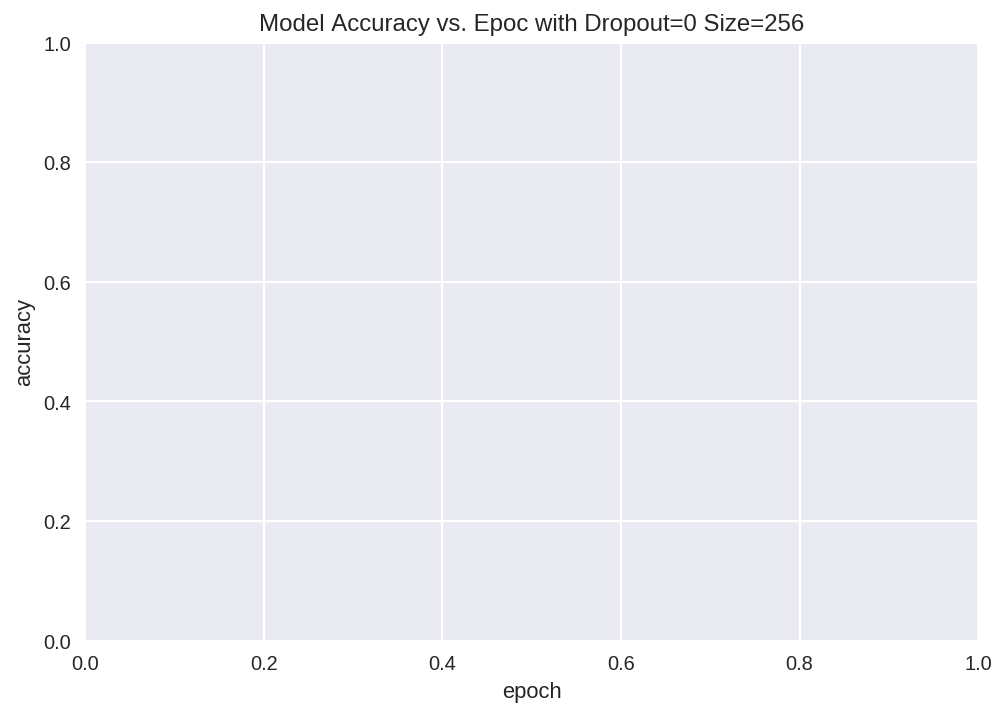

In [0]:
notes_histories = {}
duration_histories = {}

dropout, model_size = DROPOUTS, MODEL_SIZES
setup_plot(dropout, model_size)
print('Running duration training on notewise with rests:%s and root extraction:%s' % (RESTS, ROOT_EXTRACTION))
duration_callbacks, duration_weight_path = create_callback_list('duration', dropout, model_size)
duration_model = create_model(duration_training_data, duration_vocab_size, model_size, dropout)
print(duration_model.summary())
duration_histories[(dropout, model_size)] = duration_model.fit(duration_training_data, duration_training_label, epochs=EPOCHS, batch_size=DURATION_BATCH_SIZE, callbacks=duration_callbacks, validation_split=0.2)
plot_history(duration_histories[(dropout, model_size)], 'Durations', dropout, model_size)
# output intermed duration
duration_prediction = predict_duration(duration_model, duration_weight_path)

print('\n\nRunning notes training on d:%s s:%s' % (dropout, model_size))
notes_callbacks, note_weight_path = create_callback_list('notes', dropout, model_size)
notes_model = create_model(training_data, vocab_size, model_size, dropout)
notes_histories[(dropout, model_size)] = notes_model.fit(training_data, training_label, epochs=EPOCHS, batch_size=NOTE_BATCH_SIZE, callbacks=notes_callbacks, validation_split=0.2)
plot_history(notes_histories[(dropout, model_size)], 'Notes', dropout, model_size)
save_plot(GRAPHS_FOLDER + CORPUS + 'dropout=%s_size=%s' % (dropout, model_size))
# output intermed notes
note_prediction = predict_note(notes_model, note_weight_path)

# output final midi
output_midi(note_prediction, duration_prediction, dropout, model_size, "notewise-root-rest")